In [1]:
import os
import re
import string
from collections import Counter
from collections import defaultdict
from datetime import datetime
from string import punctuation
from urllib.parse import urlparse

import networkx as nx
import nltk
import pandas as pd
import matplotlib
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.util import ngrams

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
def my_ngrams(tokens, rg):
    ngrms = []
    for i in range(rg[0], rg[1] + 1):
        ngrms_aux = [ngrm for ngrm in ngrams(tokens, i)]
        ngrms.extend(ngrms_aux)
    return ngrms

# Preparing data

## Selected keywords

In [4]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [5]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [6]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [7]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords = [w.replace('\\', '').lower() for w in keywords]
keywords.sort()

In [8]:
print(keywords)

['beam me up,? scotty', 'chekhov', 'crusher', 'delta vega', 'highly illogical', 'i have been and always shall be your friend', "i'm a doctor,? not a", "i'm giving her all she's got,? captain", 'khaaa+n', 'kirk', 'klingon', 'kobayashi maru', 'live long and prosper', 'llap', 'mccoy', 'nero', 'nuclear wessels', 'nurse chapel', 'orion', 'picard', 'pike', 'prime directive', 'resistance is futile', 'romulan', 'romulan narada', 'sarek', 'scotty', 'set phasers to stun', 'space,? the final frontier', 'spock', 'star fleet', 'star trek', 'stardate', 'starship enterprise', 'sulu', 'the needs of the many outweigh the needs of the few', 'to boldly go where no man has gone before', 'transporter beam', 'uhura', 'vulcan', 'vulcan salute', 'when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth', 'without followers,? evil cannot spread']


## Comments

In [9]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': int,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': int,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna(0)

CPU times: user 28.1 s, sys: 1.77 s, total: 29.9 s
Wall time: 30.6 s


In [10]:
len(reddit_df)

2669814

In [11]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,0,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,0,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,0,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,0,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,0,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


## User network

In [12]:
graph = nx.read_gexf('user_graph.gexf')

In [13]:
graph.number_of_edges()

182127

In [14]:
graph.number_of_nodes()

136548

In [15]:
graph.number_of_selfloops()

0

# Analyzing data

In [16]:
TOP = 1000 #33

## Deleted users

In [17]:
len(reddit_df[reddit_df.author == '[deleted]'])

92302

In [18]:
reddit_df = reddit_df[reddit_df.author != '[deleted]']

In [19]:
len(reddit_df)

2577512

## Number of users

In [20]:
reddit_df.author.nunique()

634028

## In degree

In [21]:
top_indegree_t = []
for x in graph.in_degree_iter():
#     if x[1] >= 100: #33
        top_indegree_t.append(x)

In [22]:
len(top_indegree_t)

136548

In [23]:
indegree_sr = pd.Series(dict(top_indegree_t)).sort_values(ascending=False)

In [24]:
top_indegree_sr = indegree_sr.head(TOP)

In [25]:
top_indegree_sr

Algernon_Asimov        360
Willravel              301
jimmysilverrims        235
kraetos                214
ademnus                195
Darth_Rasputin32898    179
Deceptitron            173
StarTrekMike           170
MungoBaobab            167
TheCheshireCody        153
feor1300               150
nermid                 150
Flynn58                141
Antithesys             139
TimeZarg               136
Corgana                131
Kirahazen              127
regeya                 127
StarFuryG7             124
TangoZippo             122
deadfraggle            121
crapusername47         120
kwizzle                118
alchemeron             114
MHB210                 111
dannyboylee            110
Eurynom0s              108
cobrakai11             106
gloubenterder          105
rewrewsuh              104
                      ... 
nickcooper1991          15
sproket888              15
shockwave414            15
adam_mills              15
4d2                     15
jaquefroid              15
l

### In degree distribution

In [25]:
deg = []
for x in graph.in_degree_iter():
    deg.append(x)

In [26]:
deg_sr = pd.Series(dict(deg))

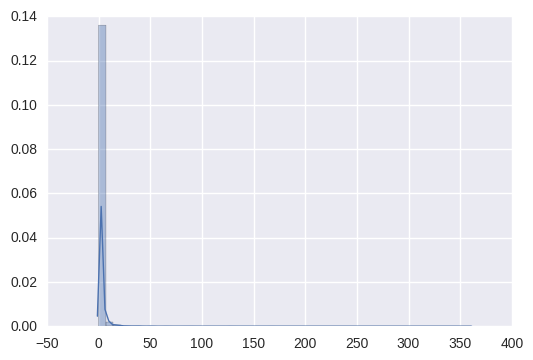

In [27]:
sns.distplot(deg_sr)

## Number of comments

In [28]:
number_of_comments_sr = reddit_df.groupby(['author'])['body'].count().sort_values(ascending=False)

In [29]:
top_comments_sr = number_of_comments_sr.head(TOP)

In [30]:
top_comments_sr

author
LokianEule              13239
imgurtranscriber         9216
qkme_transcriber         6741
Emperor-Nero             6460
CarrowCanary             5077
DavidFTyler              4829
boredcircuits            4666
GodMinos                 4644
Liz_Thorn                4468
DoxBox                   4164
Kaylum-                  4146
kwizzle                  3994
AnoK760                  3812
dreadknightnero          3641
themandotcom             3481
TeemingHail              3379
AutoModerator            3313
TheShader                3255
Aerron                   3130
AttackOnHaseeb           3097
Khallis                  3001
not_a_novel_account      2915
nssdrone                 2750
Algernon_Asimov          2735
CaptionBot               2655
scotty-doesnt-know       2639
giddythegaygopher        2541
redryan                  2521
drumstyx                 2469
tronics1                 2439
                        ...  
yeuxsee                   183
rugggy                    182
kev

## Score

In [31]:
score_sr = reddit_df.groupby(['author'])['score'].sum().sort_values(ascending=False)

In [32]:
top_score_sr = score_sr.head(TOP)

In [33]:
top_score_sr

author
CationBot              104261
Aerron                 104208
Pee_Earl_Grey_Hot       48862
scotty-doesnt-know      48065
brother_p               41801
LokianEule              34676
Emperor-Nero            26372
AnoK760                 24520
dementorpoop            23656
CruelHandLuke7          21112
ImKirkCousins           19434
RamsesThePigeon         19104
DoxBox                  18821
boredcircuits           17826
axcobb                  17036
TheShader               16215
jhl0010                 16149
wil                     15741
13thmurder              15400
boredHunt               14549
kirkgoldsberry          14446
LordAnubis10            14018
CarrowCanary            13852
liquidxlax              13818
BlacktoseIntolerant     13589
nssdrone                13289
dadudemon               13196
Algernon_Asimov         12939
Antithesys              12879
Willravel               12599
                        ...  
Agothro                  1652
Neo_Techni               1651
Jep

## Comparing data

### Common top users

In [52]:
common_indegree_comments = set(top_indegree_sr.index).intersection(top_comments_sr.index)

In [53]:
len(common_indegree_comments)

332

In [54]:
common_indegree_score = set(top_indegree_sr.index).intersection(top_score_sr.index)

In [55]:
len(common_indegree_score)

242

In [56]:
common_score_comments = set(top_score_sr.index).intersection(top_comments_sr.index)

In [57]:
len(common_score_comments)

449

In [58]:
common = set(top_indegree_sr.index).intersection(top_comments_sr.index).intersection(top_score_sr.index)

In [59]:
len(common)

152

#### => As the number of a user's comments increases, their score grows faster than their in degree.

In [36]:
def ranking(sr, x):
    return sr.index.get_loc(x) + 1

In [63]:
for c in common:
    indegree_total = int(top_indegree_sr[c])
    indegree_ranking = int(ranking(top_indegree_sr, c))
    comments_total = int(top_comments_sr[c])
    comments_ranking = int(ranking(top_comments_sr, c))
    score_total = int(top_score_sr[c])
    score_ranking = int(ranking(top_score_sr, c))
    
    graph.node[c]['show_label'] = c
    graph.node[c]['indegree_total'] = indegree_total
    graph.node[c]['indegree_ranking'] = indegree_ranking
    graph.node[c]['comments_total'] = comments_total
    graph.node[c]['comments_ranking'] = comments_ranking
    graph.node[c]['score_total'] = score_total
    graph.node[c]['score_ranking'] = score_ranking
    
    print(c)
    print('In degree:', indegree_total, '- ranking:', indegree_ranking, '/', TOP)
    print('Number of comments:', comments_total, '- ranking:', comments_ranking, '/', TOP)
    print('Score:', score_total, '- ranking:', score_ranking, '/', TOP)
    print()

TangoZippo
In degree: 122 - ranking: 20 / 1000
Number of comments: 934 - ranking: 117 / 1000
Score: 6774 - ranking: 81 / 1000

alchemeron
In degree: 114 - ranking: 24 / 1000
Number of comments: 621 - ranking: 193 / 1000
Score: 2799 - ranking: 430 / 1000

dannyboylee
In degree: 110 - ranking: 26 / 1000
Number of comments: 574 - ranking: 217 / 1000
Score: 3559 - ranking: 293 / 1000

RogueX7
In degree: 21 - ranking: 530 / 1000
Number of comments: 848 - ranking: 129 / 1000
Score: 2126 - ranking: 667 / 1000

ewiethoff
In degree: 73 - ranking: 55 / 1000
Number of comments: 834 - ranking: 132 / 1000
Score: 2399 - ranking: 549 / 1000

Deadmeat553
In degree: 24 - ranking: 425 / 1000
Number of comments: 538 - ranking: 237 / 1000
Score: 6145 - ranking: 105 / 1000

Darth_Rasputin32898
In degree: 179 - ranking: 6 / 1000
Number of comments: 1231 - ranking: 81 / 1000
Score: 5260 - ranking: 150 / 1000

i_start_fires
In degree: 54 - ranking: 83 / 1000
Number of comments: 190 - ranking: 909 / 1000
Score

### Top users' activity

In [38]:
reddit_by_month = reddit_df.groupby('month')['id'].count()

In [39]:
indegree_df = reddit_df[reddit_df.author.isin(top_indegree_sr.index)]

In [40]:
len(indegree_df)

264860

In [41]:
top_indegree_by_month = indegree_df.groupby('month')['id'].count()

In [42]:
comments_df = reddit_df[reddit_df.author.isin(top_comments_sr.index)]

In [43]:
len(comments_df)

547130

In [44]:
top_comments_by_month = comments_df.groupby('month')['id'].count()

In [45]:
score_df = reddit_df[reddit_df.author.isin(top_score_sr.index)]

In [46]:
len(score_df)

397995

In [47]:
top_score_by_month = score_df.groupby('month')['id'].count()

In [48]:
comments_by_month = pd.DataFrame({
        'all users': reddit_by_month,
        'top indegree users': top_indegree_by_month,
        'top comment users': top_comments_by_month,
        'top score users': top_score_by_month,
    })

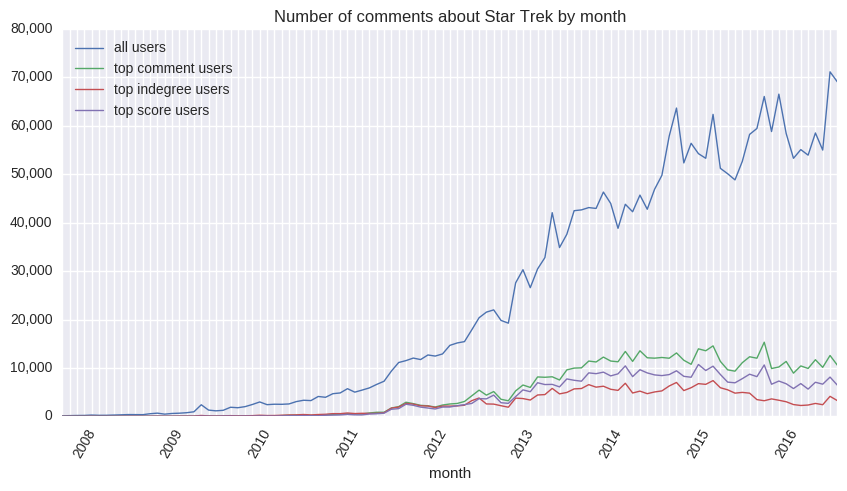

In [49]:
ax = comments_by_month.plot(
    figsize=(10,5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=comments_by_month.index,
    rot=60,
    title='Number of comments about Star Trek by month',
)
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)
# ax.set_yscale('log')

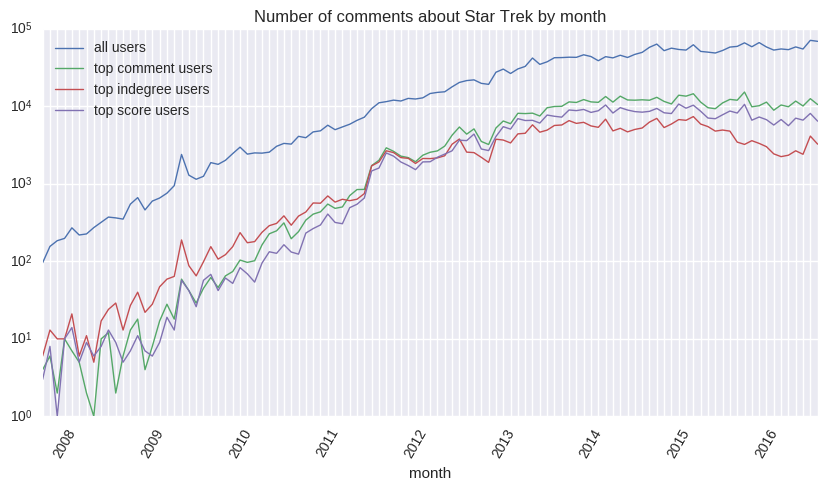

In [50]:
ax = comments_by_month.plot(
    figsize=(10,5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=comments_by_month.index,
    rot=60,
    title='Number of comments about Star Trek by month',
)
# formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
# ax.get_yaxis().set_major_formatter(formatter)
ax.set_yscale('log')

# Saving data

In [64]:
nx.write_gexf(graph, 'user_graph_2.gexf')